In [1]:
%matplotlib inline
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import io, signal # we will also import the signal module, from scipy
from PIL import Image

 ## Table Of Contents 
1. [Introduction and Background](#intro)
- [Research Question and Hypothesis](#hypothesis)
- [Data Description](#desc)
- [Data Pre-processing](#process)
- [Data Analysis](#analyze)
    1. [Time Series Analysis](#timeseries)
    2. [Power Spectral Density](#psd)
    3. [Time-Frequency Analysis](#timefreq)
    4. [Filtering](#timeseries) 
    5. [Instantaneous Power Signal](#instant)
    6. [Theta Phase Coupling](#coupling)
- [Data Results](#results)
- [Conclusions and Discussions](#conclude)
- [Considerations and Limitations](#considerations)
- [References](#refer)

<a id='intro'></a>
## Introduction

In recent years, there has been an increase in literature devoted to understanding the functional contributions of neural oscillations. Many of these studies investigate the relationship between brain regions and synchronous neural oscillations and their role in motor processes (Salenius, S., & Hari, R, 2003; MacKay, W. A., 1997).
It is suspected that synchronous neural oscillations that occur globally rather than locally give rise to conscious awareness (Ward, L.M., 2003).


<a id='hypothesis'></a>
## Research Question & Hypothesis

**Research Question:** How do oscillation frequencies compare during slow wave sleep and wakefulness across the brain regions? Is there an oscillatory basis for consciousness? 

**Hypothesis:**


<a id='desc'></a>

## Dataset

### Monkey Resting ECoG Data
Recorded from monkey whole cortex. ECoG sampled at 1000Hz, 3 channels. From **Yanagawa et al., PLOS ONE, 2013.**

In this experiment, the monkey is sitting in a chair with no task demands. 5 minutes of data each are provided during 3 different stages: awake awake, awake eyes closed, and anesthesized. They are stored in `ecog_eyesopen`,`ecog_eyesclosed`, and `ecog_anes` respectively. The sampling rate is provided, from which you can compute the time vectors (they can have their own time vectors all starting from 0s).

`labels` contains information about which brain regions the 3 channels are located in, while `elec_num` has the electrode number, which you can find on the brain map image included in the same folder (brainmap.jpg).

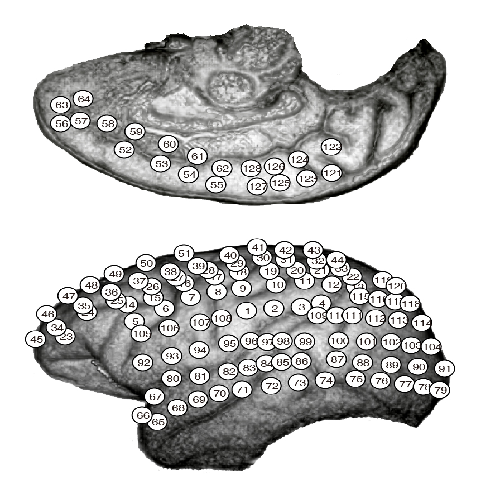

In [2]:
img = Image.open('ECoG_monkey/brainmap.jpg').resize((500,500))
img

<a id='process'></a>

## Data Pre-Processing

In [3]:
monkey_ecog_data = io.loadmat('ECoG_monkey/ECoG_monkey.mat', squeeze_me = True)

eyesopen_cingulate = monkey_ecog_data['ecog_eyesopen'][0,:]
eyesopen_occipital = monkey_ecog_data['ecog_eyesopen'][1,:]
eyesopen_temporal = monkey_ecog_data['ecog_eyesopen'][2,:]


anes_cingulate =  monkey_ecog_data['ecog_anes'][0,:]
anes_occipital =  monkey_ecog_data['ecog_anes'][1,:]
anes_temporal =  monkey_ecog_data['ecog_anes'][2,:]

elec_num = monkey_ecog_data['elec_num']
fs = monkey_ecog_data['fs']
regions = monkey_ecog_data['labels']
states = ['Awake','Anesthesia']
N = eyesopen_cingulate.shape[0]
t_vector = np.arange(0, N/fs, 1/fs)
colors = ['midnightblue','darkmagenta','steelblue','c', 'mediumseagreen', 'darkorange']
dt = 1 / fs
T_exp = len(eyesopen_cingulate) 

<a id='analyze'></a>

# Data Analysis

<a id='analyze'></a>

## 1. Time Series Analysis

In [4]:
def plot_time_series(data1, label1, data2, label2, title, data3=None, label3=None):
    plt.figure(figsize=(15,3))
    plt.plot(t_vector, data1, label=label1, c='darkmagenta')
    plt.plot(t_vector, data2, label=label2, c='steelblue')
    if data3 is not None:
        plt.plot(t_vector, data3, label=label3, c='darkorange')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (uV)')
    plt.xlim([0,5])
    plt.ylim([-2000, 2000])
    plt.title(title + " Time Series")

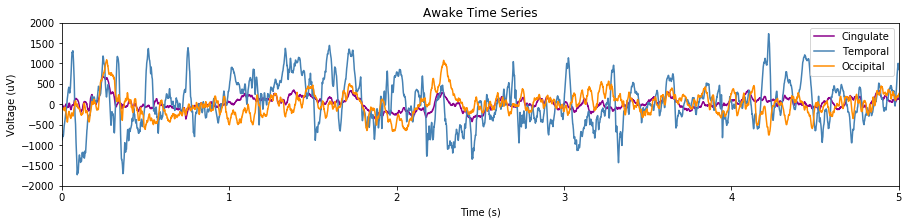

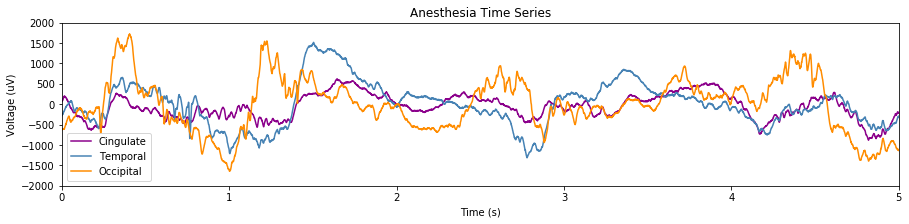

In [5]:
plot_time_series(eyesopen_cingulate, 'Cingulate', eyesopen_temporal, 'Temporal', 'Awake', eyesopen_occipital, 'Occipital')
plot_time_series(anes_cingulate, 'Cingulate', anes_temporal, 'Temporal', 'Anesthesia', anes_occipital, 'Occipital')

Here we plot a time series comparing the awake and anesthetized data for all brain regions. From a first glance, it appears that awake data has a higher frequency than anesthetized data. We will explore this further.

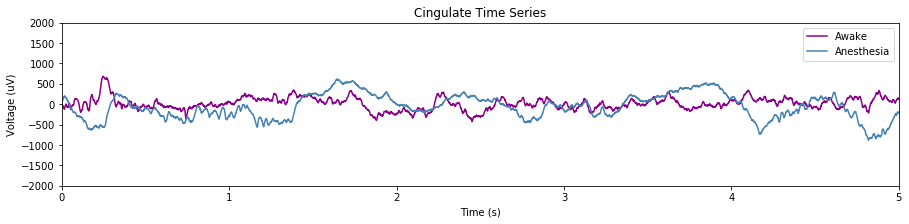

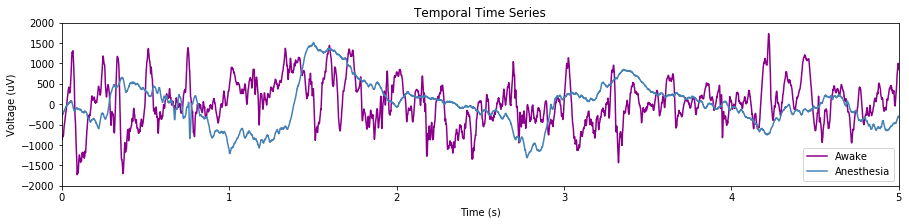

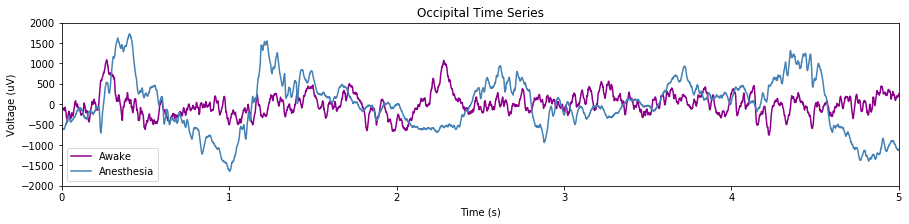

In [6]:
plot_time_series(eyesopen_cingulate, 'Awake', anes_cingulate, 'Anesthesia', 'Cingulate')
plot_time_series(eyesopen_temporal, 'Awake', anes_temporal, 'Anesthesia', 'Temporal')
plot_time_series(eyesopen_occipital, 'Awake', anes_occipital, 'Anesthesia', 'Occipital')

A deeper look into the time series reveals that temporal data seems to have a lower frequency over awake data. So far, nothing more can be said about the other regions prior to frequency analysis.  

<a id='psd'></a>

## 2.  PSD State Comparisons

In [7]:
brain_wave_names = ['Delta Component', 'Theta Component', 'Alpha Component', 'Beta Component', 'Gamma Component']
bandpass_values = [[0.5,4], [4,8], [8,13], [13,32], [32,100]]

In [8]:
def return_PSD_data(data):
    f_sp, t_sp, psd = signal.spectrogram(data, fs, mode = 'psd')
    psd = np.array([i.mean() for i in psd])
    return f_sp, t_sp, psd

In [9]:
def plot_PSD_state(f_sp, open_psd, anes_psd):
    plt.plot(f_sp, open_psd,label = 'Awake', color = colors[1])
    plt.plot(f_sp, anes_psd,label = 'Anesthesia', color = 'steelblue')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.yscale("log")
    plt.xlim(-5,500)
    plt.legend()
    
def plot_PSD_region(f_sp, temp_psd, occ_psd, cing_psd):
    plt.plot(f_sp, temp_psd,  label = 'Temporal', color = colors[1])
    plt.plot(f_sp, occ_psd, label = 'Occipital', color = colors[3])
    plt.plot(f_sp, cing_psd, label = 'Cingulate', color = colors[4])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.yscale("log")
    plt.xlim(-5,500)
    plt.legend()

In [10]:
open_temp_f_sp, open_temp_t_sp, open_temp_psd = return_PSD_data(eyesopen_temporal)
anes_temp_f_sp, anes_temp_t_sp,  anes_temp_psd = return_PSD_data(anes_temporal)

open_occ_f_sp, open_occ_t_sp, open_occ_psd = return_PSD_data(eyesopen_occipital)
anes_occ_f_sp, anes_occ_t_sp,  anes_occ_psd = return_PSD_data(anes_occipital)

open_cing_f_sp, open_cing_t_sp, open_cing_psd = return_PSD_data(eyesopen_cingulate)
anes_cing_f_sp, anes_cing_t_sp, anes_cing_psd = return_PSD_data(anes_cingulate)

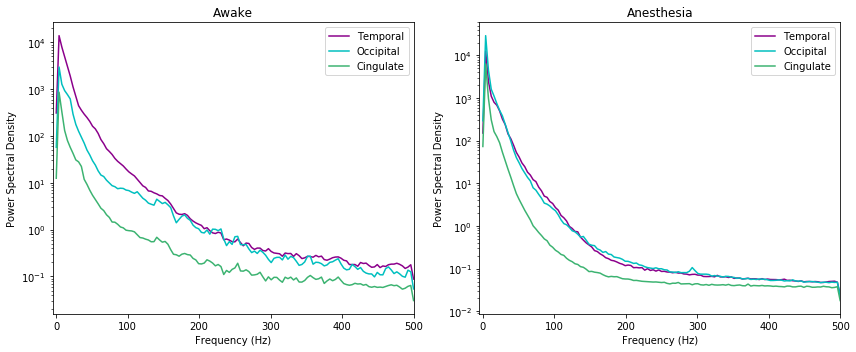

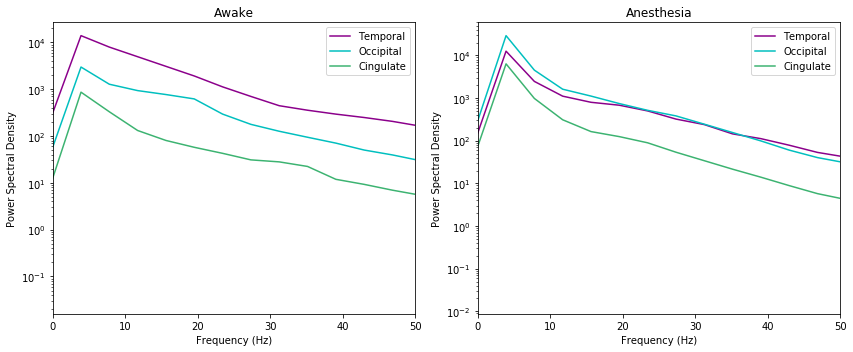

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(states[0])
plot_PSD_region(open_temp_f_sp, open_temp_psd, open_occ_psd, open_cing_psd)

plt.subplot(1,2,2)
plt.title(states[1])
plot_PSD_region(anes_temp_f_sp, anes_temp_psd, anes_occ_psd, anes_cing_psd)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(states[0])
plot_PSD_region(open_temp_f_sp, open_temp_psd, open_occ_psd, open_cing_psd)
plt.xlim([0,50])

plt.subplot(1,2,2)
plt.title(states[1])
plot_PSD_region(anes_temp_f_sp, anes_temp_psd, anes_occ_psd, anes_cing_psd)
plt.tight_layout()
plt.xlim([0,50])

plt.show()

Upon analyzing the power spectral density, we can see that about 4Hz contributes the most to both the awake and anesthetized signal. Each cortical area shows this same 4Hz contribution. This signifies that the underlying dominant frequency is from either the delta (0.5-8Hz) or theta (4-8Hz) band. 

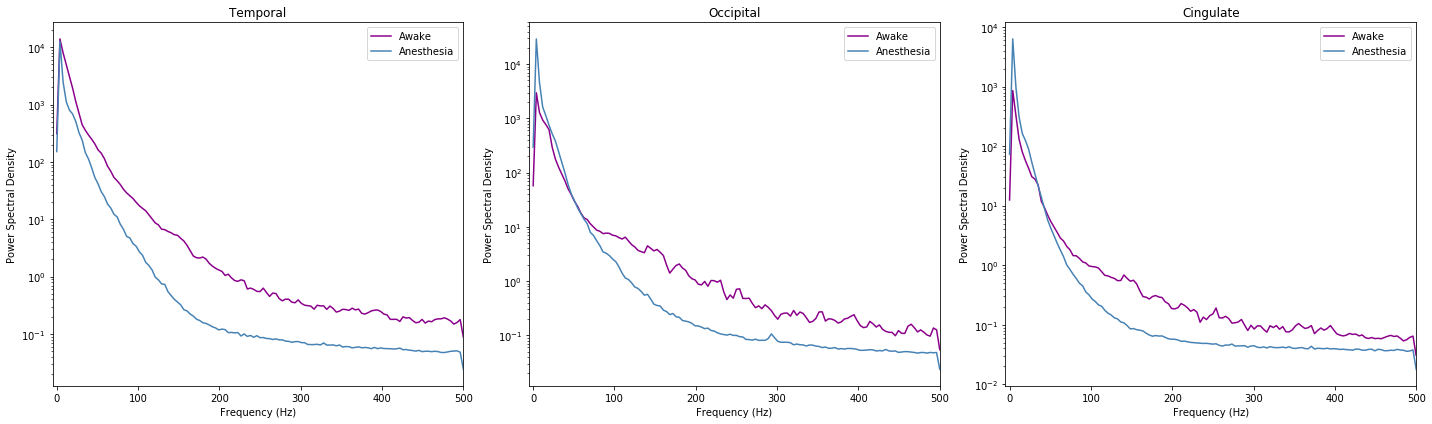

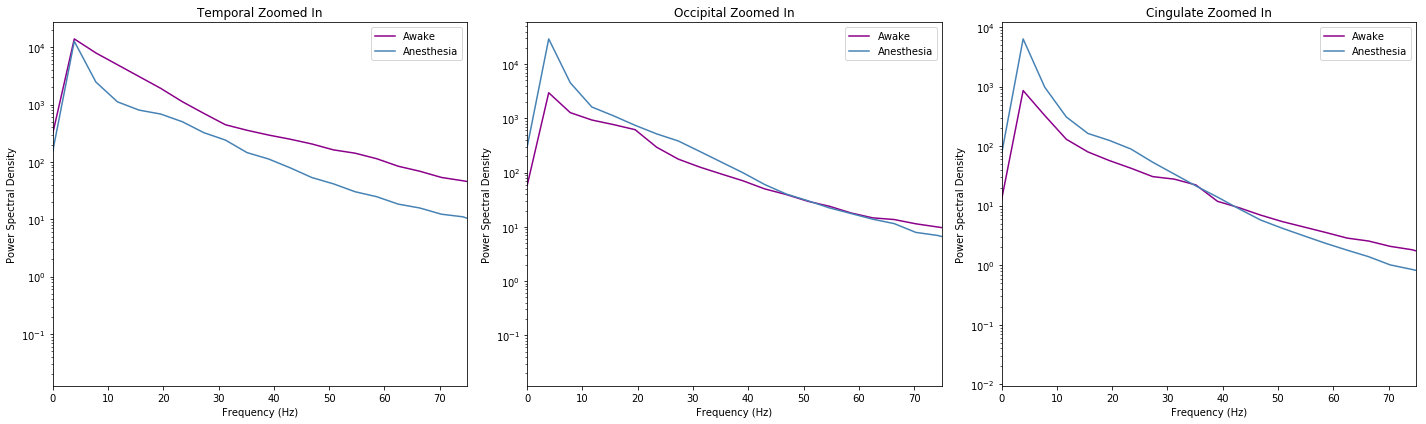

In [12]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.title('Temporal')
plot_PSD_state(open_temp_f_sp, open_temp_psd, anes_temp_psd)

plt.subplot(1,3,2)
plt.title('Occipital')
plot_PSD_state(open_occ_f_sp, open_occ_psd, anes_occ_psd)

plt.subplot(1,3,3)
plt.title('Cingulate')
plot_PSD_state(open_cing_f_sp, open_cing_psd,anes_cing_psd)
plt.tight_layout()

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.title('Temporal Zoomed In')
plot_PSD_state(open_temp_f_sp, open_temp_psd, anes_temp_psd)
plt.xlim([0,75])

plt.subplot(1,3,2)
plt.title('Occipital Zoomed In')
plot_PSD_state(open_occ_f_sp, open_occ_psd, anes_occ_psd)
plt.xlim([0,75])

plt.subplot(1,3,3)
plt.title('Cingulate Zoomed In')
plot_PSD_state(open_cing_f_sp, open_cing_psd,anes_cing_psd)
plt.tight_layout()
plt.xlim([0,75])

plt.show()

Furthermore, awake signals contain stronger frequencies at all ranges compared to anesthetized signals. However, both the occipital and cingulate cortices dominate in lower frequencies for anesthetized signals. At about 50 Hz and 42 Hz respectively, awake signals become stronger than anesthetized signals at the higher frequency ranges. 

<a id='timefreq'></a>

## 3. Time-Frequency Analysis: STFT & Spectrogram

In [13]:
def spectrogram_calibration(spg, t, f, freq_lims=[0,100], plot_db=False):
    """
    Utility function for plotting the spectrogram for you.
    
    spg: spectrogram, 2D real-numbered array, dimensions are [frequency x time]
    t: time axis of spectrogram
    f: frequency axis of spectrogram
    freq_lims (optional): limits the frequency axis, defaults to 0-100Hz
    """
    plt.figure(figsize=(15,4))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect ='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()

In [14]:
def plot_spectrogram(data, len_win, len_overlap):
    f_sp, t_sp, spg_sp = signal.spectrogram(data, fs, window='rect', \
    nperseg=int(fs*len_win), noverlap=int(fs*len_overlap), detrend=False)
    spg_sp = spg_sp*fs**2*len_win/2
    spectrogram_calibration(np.log10(spg_sp), t_sp, f_sp, plot_db=False)

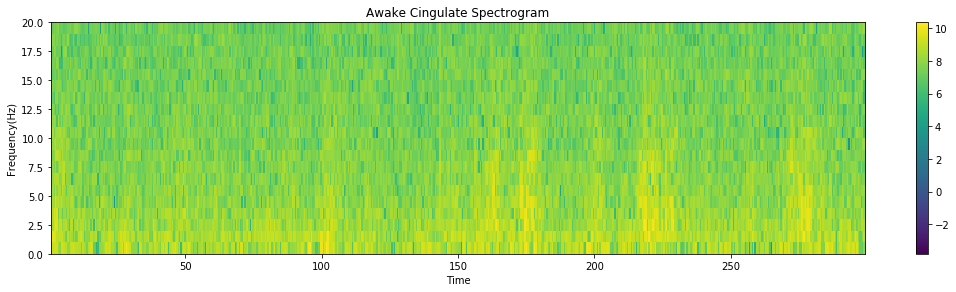

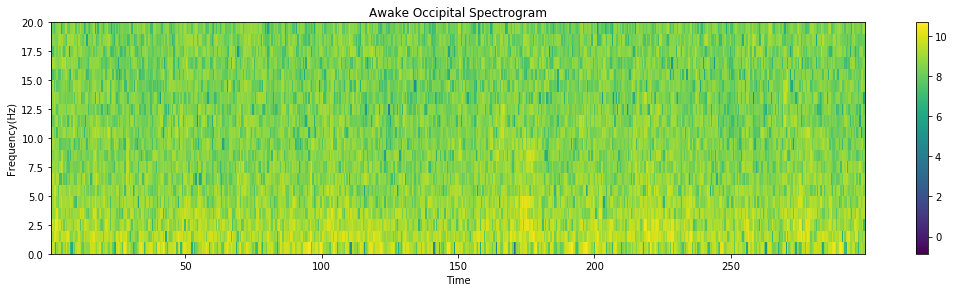

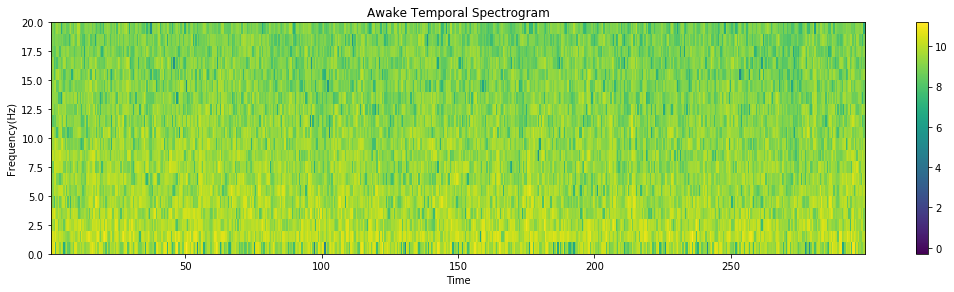

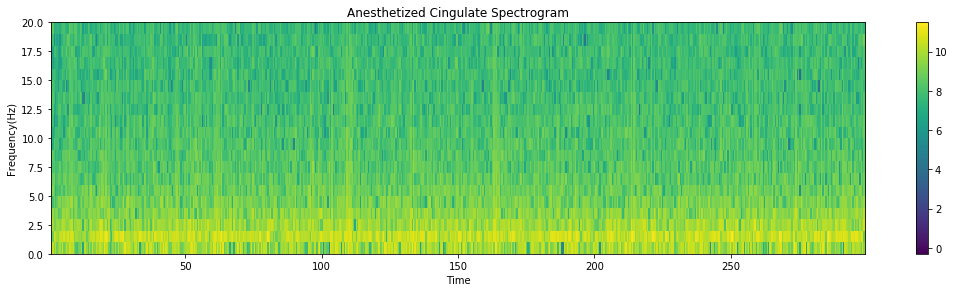

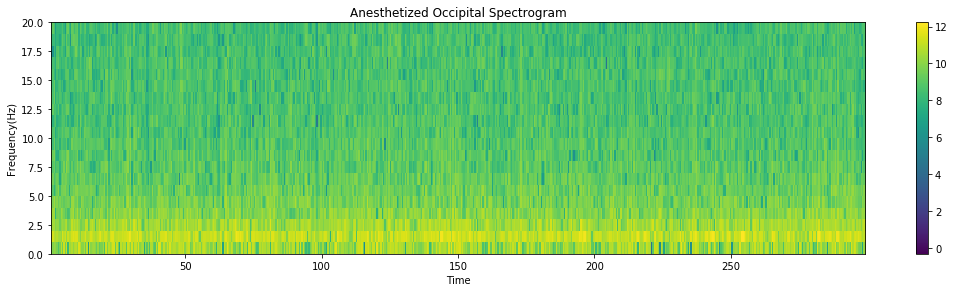

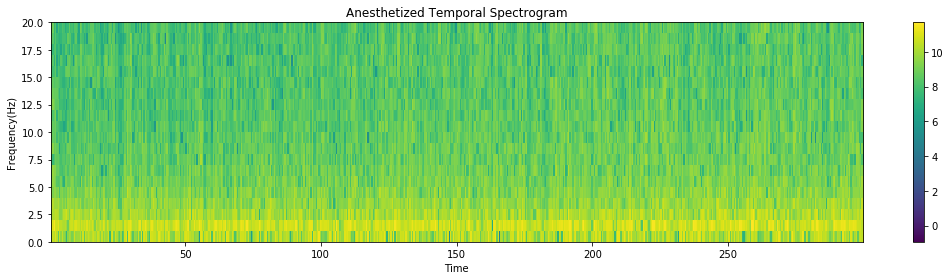

In [15]:
len_win = 1
len_overlap = 0.5
ylims = [0,20]

plot_spectrogram(eyesopen_cingulate, len_win, len_overlap)
plt.title('Awake Cingulate Spectrogram')
plt.ylim(ylims)

plot_spectrogram(eyesopen_occipital, len_win, len_overlap)
plt.title('Awake Occipital Spectrogram')
plt.ylim(ylims)

plot_spectrogram(eyesopen_temporal, len_win, len_overlap)
plt.title('Awake Temporal Spectrogram')
plt.ylim(ylims)

plot_spectrogram(anes_cingulate, len_win, len_overlap)
plt.title('Anesthetized Cingulate Spectrogram')
plt.ylim(ylims)

plot_spectrogram(anes_occipital, len_win, len_overlap)
plt.title('Anesthetized Occipital Spectrogram')
plt.ylim(ylims)

plot_spectrogram(anes_temporal, len_win, len_overlap)
plt.title('Anesthetized Temporal Spectrogram')
plt.ylim(ylims)

plt.tight_layout()
plt.show()

The spectrograms for the awake data is noticeably brighter than the spectrograms for the anesthesized data, aside from the very low frequencies (< 2.5Hz). This allows us to conclude that higher frequencies are more present during the awake state than the anesthesized state.

<a id='filter'></a>

## 4. Filtering Each Brainwave

We apply a bandpass filter for each of the brainwaves, filtering out the rest of the frequencies.

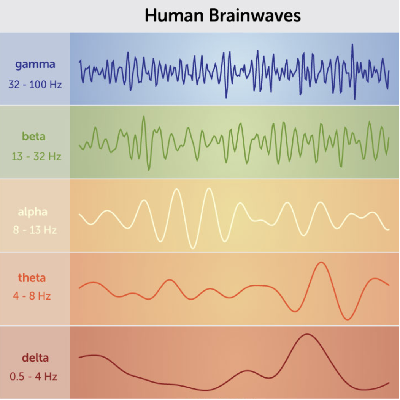

In [16]:
brainwaves = Image.open('ECoG_monkey/Brainwaves.png').resize((400,400))
brainwaves

### Temporal Lobe: Awake State

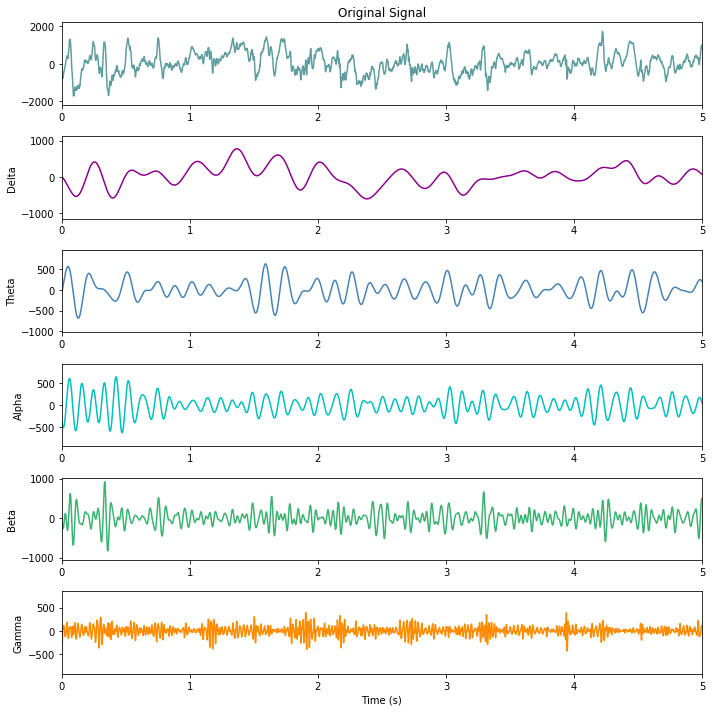

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(6,1,1)
plt.plot(t_vector, eyesopen_temporal, color = 'cadetblue') #plot original signal
plt.title("Awake Signal")
plt.xlim(0,5)

y_labels = ['Delta','Theta','Alpha','Beta','Gamma']

for i in range(5):
    FIR = signal.firwin(751, bandpass_values[i], fs = fs, pass_zero = False)
    oscillation = np.convolve(eyesopen_temporal, FIR, mode='same')
    #plot filtered oscillation across time
    plt.subplot(6,1,i+2)
    plt.plot(t_vector, oscillation, color = colors[i+1])
    plt.ylabel(y_labels[i])
    plt.xlim([0,5])
    
plt.xlabel('Time (s)')
plt.tight_layout()

These are the different brainwaves that make up a single reading from the brain. More specifically, this is the deconstructed signal of temporal lobe with the awake.  
Note the delta component.

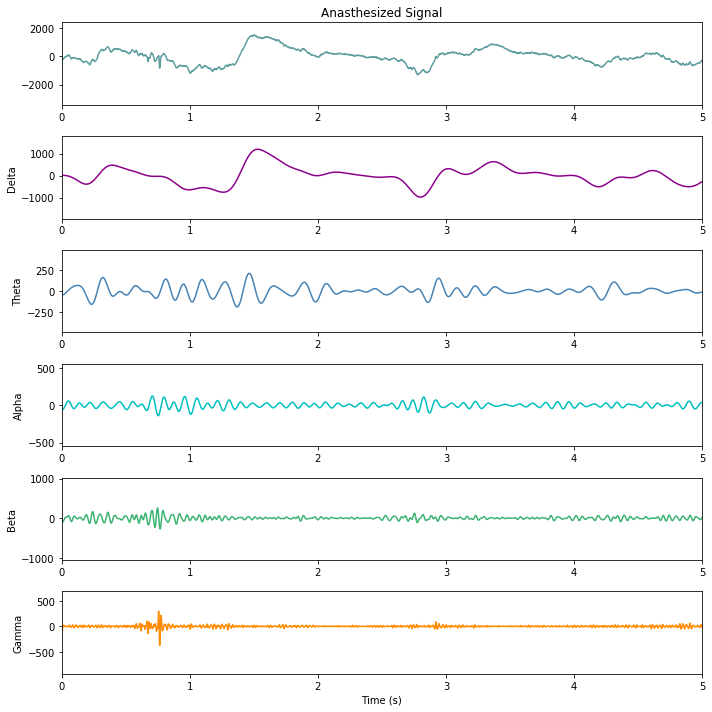

In [29]:
plt.figure(figsize=(10,10))
plt.subplot(6,1,1)
plt.plot(t_vector, anes_temporal, color = 'cadetblue') #plot original signal
plt.title("Anasthesized Signal")
plt.xlim(0,5)

y_labels = ['Delta','Theta','Alpha','Beta','Gamma']

for i in range(5):
    FIR = signal.firwin(751, bandpass_values[i], fs = fs, pass_zero = False)
    oscillation = np.convolve(anes_temporal, FIR, mode='same')
    #plot filtered oscillation across time
    plt.subplot(6,1,i+2)
    plt.plot(t_vector, oscillation, color = colors[i+1])
    plt.ylabel(y_labels[i])
    plt.xlim(0,5)

plt.xlabel('Time (s)')
plt.tight_layout()

These are the frequency components of the the anesthetized temporal lobe.  
Note the difference between the delta, alpha, beta, and gamma components compared to the awake components. 

<a id='instant'></a>

## 5. Instantaneous Power Signal for Theta Oscillations 

In this section, we compute the analytic signal (omitting the negative frequencies) and compute the instantaneous power of the theta frequency through time in order to gauge whether or not theta oscillations are regular and continuous for all states. 

In [19]:
#plots the instantaneous power signal for a particular oscillation
def plot_theta_osc(data, cutoff):
    num_rows = 2
    num_columns = 1
    for i in range(num_rows):
        plt.subplot(num_rows,num_columns, i+1)
        FIR_theta_alpha = signal.firwin(800, cutoff, fs=fs, pass_zero=False)
        theta_alpha_osc = np.convolve(data[i], FIR_theta_alpha,mode='same')
        x_a_theta_alpha = signal.hilbert(theta_alpha_osc)
        plt.ylabel("Voltage")
        plt.xlabel("Time")
        plt.title(states[i])
        plt.xlim(0,30)
        theta_power = np.abs(x_a_theta_alpha)**2
        plt.plot(t_vector, theta_power, color = colors[i])
    plt.tight_layout()

### Theta Oscillations in Temporal Cortex

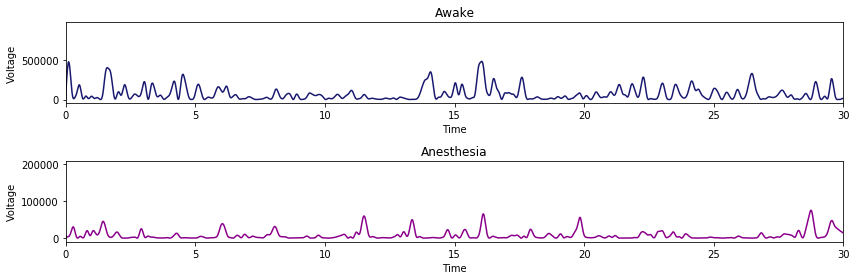

In [20]:
plt.figure(figsize=(12,4))
plot_theta_osc([eyesopen_temporal,  anes_temporal], [4,8])

### Theta Oscillations in Occipital Cortex

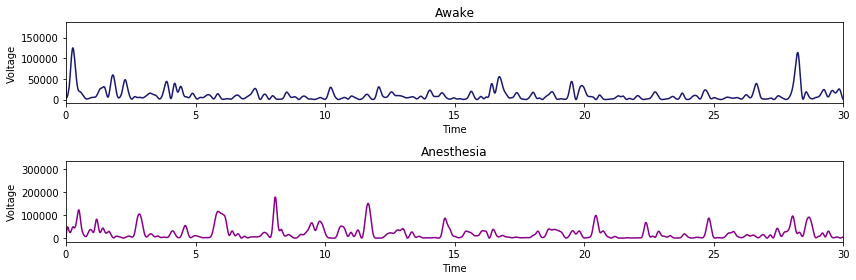

In [21]:
plt.figure(figsize=(12,4))
plot_theta_osc([eyesopen_occipital, anes_occipital], [4,8])

### Theta Oscillations in the Cingulate

Look at the DFT of the theta oscillations to see how frequent the theta oscillations are.

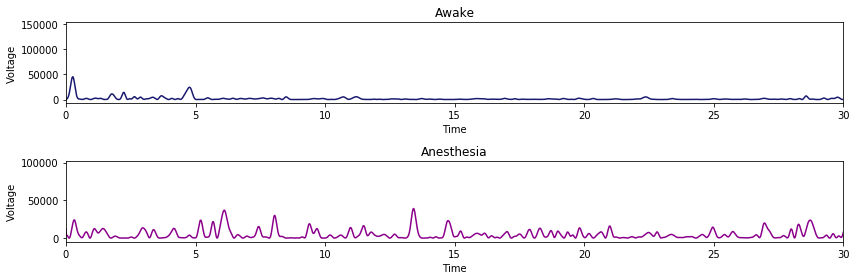

In [22]:
plt.figure(figsize=(12,4))
plot_theta_osc([eyesopen_cingulate, anes_cingulate], [4,8])

In [23]:
def compute_power_phase(x_a):
     
    return (np.abs(x_a)**2), np.angle(x_a)

#theta_power, theta_phase = compute_power_phase(x_a_theta)

<a id='coupling'></a>

## Theta Phase Coupling Between Regions

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


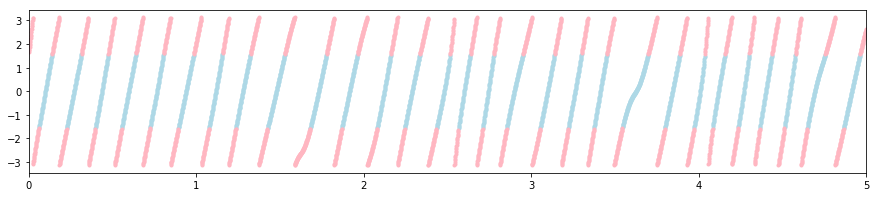

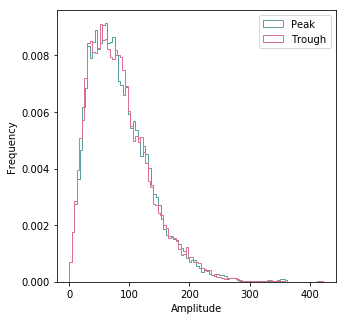

In [24]:
# compute gamma power and phase
FIR_theta =  signal.firwin(800, [4,8], fs=fs, pass_zero=False)
theta_osc = np.convolve(eyesopen_occipital, FIR_theta,mode='same')

x_a_theta = signal.hilbert(theta_osc)
theta_power, theta_phase =  compute_power_phase(x_a_theta)

peak_inds = np.where(np.logical_and(theta_phase>-np.pi/2, theta_phase<np.pi/2))[0]
trough_inds = np.where(np.logical_or(theta_phase<-np.pi/2, theta_phase>np.pi/2))[0]

plt.figure(figsize=(15,3))

# plot the theta peak and trough phases
plt.plot(t_vector[peak_inds], theta_phase[peak_inds], '.', color = 'lightblue', label = 'Theta Peak')
plt.plot(t_vector[trough_inds], theta_phase[trough_inds], '.', color = 'lightpink', label = 'Theta Trough')
plt.xlim(0,5)

# plot the gamma power corresponding to theta peak and trough phases
#plt.plot(t_vector[peak_inds], theta_power[peak_inds], '.', color = 'cadetblue', label ='Theta Peak')
#plt.plot(t_vector[trough_inds], theta_power[trough_inds], '.', color = 'palevioletred', label = 'Gamma Trough')
#plt.xlabel("Time (s)")
#plt.ylabel("")
#plt.xlim(0,2)
#plt.legend()

plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist((theta_power[peak_inds])**(1/2), 100, color='cadetblue',normed=True, histtype='step', label='Peak');
plt.hist((theta_power[trough_inds])**(1/2), 100, color='palevioletred',normed=True, histtype='step', label='Trough');
plt.ylabel("Frequency")
plt.xlabel("Amplitude")
plt.legend()



<a id='results'></a>

## Data Results


<a id='conclude'></a>

## Conclusion & Discussions

<a id='considerations'></a>
## Considerations & Limitations

NameError: name 'eyesclosed_occipital' is not defined

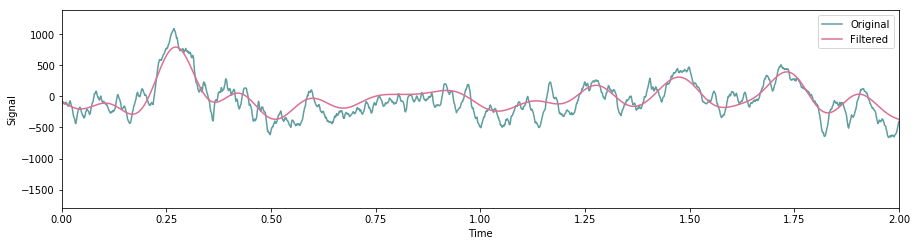

In [25]:
FIR_theta_alpha = signal.firwin(751, [1,8], fs=fs, pass_zero=False)
theta_alpha_osc = np.convolve(eyesopen_occipital, FIR_theta_alpha,mode='same')
x_a_theta_alpha = signal.hilbert(theta_alpha_osc)
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
# plot the signal and the filtered signal
plt.plot(t_vector, eyesopen_occipital, color = 'cadetblue', label='Original')
plt.plot(t_vector, theta_alpha_osc,color = 'palevioletred', label='Filtered')
plt.ylabel("Signal")
plt.xlabel("Time")
plt.xlim(0,2)
plt.legend()



FIR_alpha = signal.firwin(2000, [1,13], fs=fs, pass_zero=False)
alpha_osc = np.convolve(eyesclosed_occipital, FIR_alpha,mode='same')
x_a_alpha = signal.hilbert(alpha_osc)

plt.subplot(2,1,2)
# plot the signal and the filtered signal
plt.plot(t_vector, eyesclosed_occipital, color = 'cadetblue', label='Original')
plt.plot(t_vector, alpha_osc,color = 'palevioletred', label='Filtered')
plt.ylabel("Signal")
plt.xlabel("Time")
plt.xlim(0,2)
plt.legend()

In [ ]:
FIR_theta_alpha = signal.firwin(751, [1,10], fs=fs, pass_zero=False)
theta_alpha_osc = np.convolve(eyesopen_temporal, FIR_theta_alpha,mode='same')
x_a_theta_alpha = signal.hilbert(theta_alpha_osc)
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
# plot the signal and the filtered signal
plt.plot(t_vector, eyesopen_temporal, color = 'cadetblue', label='Original')
plt.plot(t_vector, theta_alpha_osc,color = 'palevioletred', label='Filtered')
plt.ylabel("Signal")
plt.xlabel("Time")
plt.title("Awake Temporal")
plt.xlim(0,2)
plt.legend()



FIR_alpha = signal.firwin(2000, [1,13], fs=fs, pass_zero=False)
alpha_osc = np.convolve(eyes_closed_temporal, FIR_alpha,mode='same')
x_a_alpha = signal.hilbert(alpha_osc)

plt.subplot(2,1,2)
# plot the signal and the filtered signal
plt.plot(t_vector, eyes_closed_temporal, color = 'cadetblue', label='Original')
plt.plot(t_vector, alpha_osc,color = 'palevioletred', label='Filtered')
plt.ylabel("Signal")
plt.xlabel("Time")
plt.title("Eyes Closed Temporal")
plt.xlim(0,2)
plt.legend()
plt.tight_layout()

<a id='refer'></a>
## References & Contributions